# Homework 7
04/03/20

Rixin Li & G . Besla

Completed by Emily Walla

In [1]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [2]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """
        inputs:
                filename: the name of the file in which you will store the integrated orbit
        """

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        
        self.filename = filename
        
        
        ### get the current pos/vel of M33
        path = "/home/astr400b/HighRes/"
        delta = 0.1 ; VolDec = 4

        # **** create an instance of the  CenterOfMass class for M33 
        M33_COM = CenterOfMass(path+"M33_000.txt",2)
        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        self.M33_COMP = M33_COM.COM_P(delta, VolDec)
        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        self.M33_COMV = M33_COM.COM_V(self.M33_COMP[0], self.M33_COMP[1], self.M33_COMP[2])
        
        ### get the current pos/vel of M31 
        
        # **** create an instance of the  CenterOfMass class for M31 
        M31_COM = CenterOfMass(path+"M31_000.txt",2)
        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        self.M31_COMP = M31_COM.COM_P(delta, VolDec)
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        self.M31_COMV = M31_COM.COM_V(self.M31_COMP[0], self.M31_COMP[1], self.M31_COMP[2])
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = self.M33_COMP - self.M31_COMP
        self.v0 = np.array([self.M33_COMV[0] - self.M31_COMV[0],self.M33_COMV[1]-self.M31_COMV[1],self.M33_COMV[2]-self.M31_COMV[2]])
        self.x = self.r0[0];  self.y = self.r0[1];  self.z = self.r0[2]
        self.vy = self.v0[0]; self.vy = self.v0[1]; self.vz = self.v0[2]
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5 # (kpc)

        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass(path+"M31_000.txt",2)*1e12
        
        
        self.disk = np.array([self.Mdisk.value,self.rdisk])
        
        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1
        
        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass(path+"M31_000.txt",3)*1e12
        
        self.bulge = np.array([self.Mbulge.value, self.rbulge])
        
        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 62

        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass(path+"M31_000.txt",1)*1e12
        
        self.halo = np.array([self.Mhalo.value, self.rhalo])
    
        
    def HernquistAccel(self,part,r): # it is easiest if you take as an input the position VECTOR 
        """ function to compute the acceleration induced by a Hernquist Profile """
        """
        inputs: part: self.halo or self.bulge
                r: a 3-vector position
        """
        r_a = part[1]
        M = part[0]
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt((r[0]**2)+(r[1]**2)+(r[2]**2))
        
        ### *** Store the Acceleration
        Hern =  -((self.G*M)/(rmag*(r_a+rmag)**2))*r
        
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self,M, rd, r):# it is easiest if you take as an input a position VECTOR  r 
        """ function computes acceleration based on a Miyamoto-Nagai 1975 Profile
        
        inputs: r: a 3-array of a position from the center of M31
        returns: acceleration 3-vector
        """
        
        # declare variables
        G = self.G
        x = r[0]
        y = r[1] 
        z = r[2] 
        zd = self.rdisk/5.0
        
        # make typing the acceleration easier on myself
        R = np.sqrt(x**2 + y**2)
        B = rd + np.sqrt(z**2 + zd**2)
        xy_denom = (R**2 + B**2)**1.5
        
        
        # calculate x-acceleration
        ax = -(G*M*x)/(xy_denom)
        # calculate y-acceleration
        ay = -(G*M*y)/(xy_denom)
        # calculate z-acceleration
        az = -(G*M*B*z)/(xy_denom*(B-rd))
        
       
        return np.array([ax,ay,az])
        
     
    
    def M31Accel(self,r): # input should include the position vector, r
        """ Function sums over the three different component accelerations
            to get total acceleration of M31
            
        inputs: r: a position vector
        returns: the summed acceleration vector
        """
                        

        ### Call the previous functions for the halo, bulge and disk
        
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc.
        aHalo = self.HernquistAccel(self.halo,r)
        aBulge = self.HernquistAccel(self.bulge,r)
        aDisk = self.MiyamotoNagaiAccel(self.Mdisk.value,self.rdisk,r)
        
        
            
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return np.array([aHalo[0]+aBulge[0]+aDisk[0], aHalo[1]+aBulge[1]+aDisk[1], aHalo[2]+aBulge[2]+aDisk[2]])
    
    
    
    def LeapFrog(self,dt,r,v): # ake as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """ function that "leap-frogs" to get new position and velocity vectors
        
        inputs: dt: the time-step
                r : the 3-vector position
                v : the 3-vector velocity
    
        returns: rnew, venw: the new position and velocity vectors
        """
        
        # predict the position at the next half timestep
        rhalf = np.array([r[0]+v[0]*dt/2, r[1]+v[1]*dt/2, r[2]+v[2]*dt/2])
        
        a = self.M31Accel(rhalf)
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = np.array([v[0]+a[0]*dt, v[1]+a[1]*dt, v[2]+a[2]*dt])
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = np.add(rhalf,vnew*dt/2)
        
        return rnew, vnew # **** return the new position and velcoity vectors
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ function integrates over time to calculate orbital positions
        
        inputs: t0: initial time (Gyr)
                dt: timestep   (Gyr)
                tmax: maximum time (Gyr)
                
        writes the data to .txt file
        """

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt)+2,7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t<tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t = t+dt
            # **** store the new time in the first column of the ith row
            orbit[i,0] = t 
            r = orbit[i-1,1:4]
            v = orbit[i-1,4:7]
            # ***** advance the position and velocity using the LeapFrog scheme
            rnew, vnew = self.LeapFrog(dt,r,v)
            orbit[i,1:7] = *tuple(rnew), *tuple(vnew)
            
            # remember that LeapFrog returns a position vector and a velocity vector  
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i = i+1
        
        
        # write the data to a file
        np.savetxt(self.filename+".txt", orbit, header="t x y z vx vy vz", comments="#", fmt=["%.2f","%.2f","%.2f","%.2f","%.2f","%.2f","%.2f"])
   
        
        # there is no return function

In [3]:
Orbit = M33AnalyticOrbit("M33AnalyticalOrbit")

In [4]:
Orbit.OrbitIntegration(0,.001,10)

In [5]:
# extract information from the text file
#x = np.genfromtxt("M33AnalyticalOrbit.txt", delimiter=" ",usecols=2)
t, x, y, z, vx, vy, vz = np.genfromtxt("M33AnalyticalOrbit.txt",delimiter=" ", unpack = True)

In [6]:
# get the M33-M31 distance
r = np.sqrt(x**2+y**2+z**2)
# and the velocity
v = np.sqrt(vx**2 + vy**2 + vz**2)

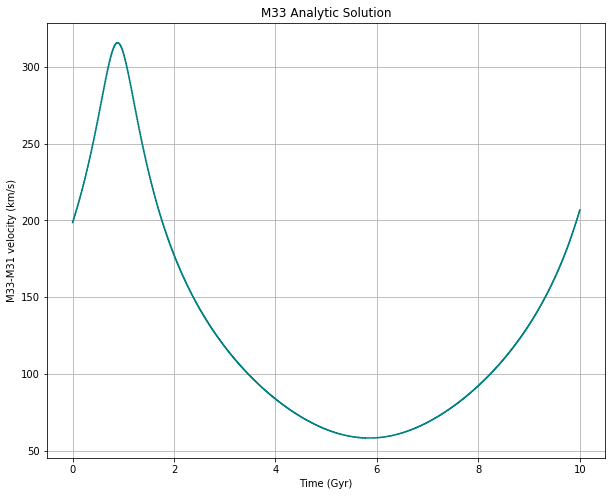

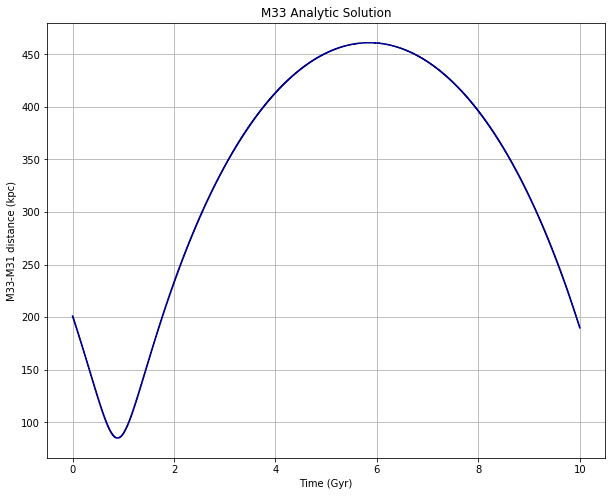

In [7]:
# plot!
plt.figure(figsize=(10,8))
plt.plot(t,v, color="teal", label="velocity")
plt.title("M33 Analytic Solution")
plt.ylabel("M33-M31 velocity (km/s)")
plt.xlabel("Time (Gyr)")
plt.grid()
plt.show()

plt.figure(figsize=(10,8))
plt.plot(t,r, color="darkblue",label="separation")
plt.title("M33 Analytic Solution")
plt.ylabel("M33-M31 distance (kpc)")
plt.xlabel("Time (Gyr)")
plt.grid()
plt.show()

In [8]:
# compare this result to the older result:
# read in older result from text file:
M31t, M31x, M31y, M31z, M31vx, M31vy, M31vz = np.genfromtxt("../Homework6/Orbit_M31.txt",delimiter=" ", unpack = True)
M33t, M33x, M33y, M33z, M33vx, M33vy, M33vz = np.genfromtxt("Orbit_M33.txt",delimiter=" ", unpack = True)
dx = M33x-M31x
dy = M33y-M31y
dz = M33z-M31z
dvx = M33vx - M31vx
dvy = M33vy - M31vy
dvz = M33vz - M31vz
M33r = np.sqrt(dx**2 + dy**2 + dz**2)
M33v = np.sqrt(dvx**2 + dvy**2 + dvz**2)

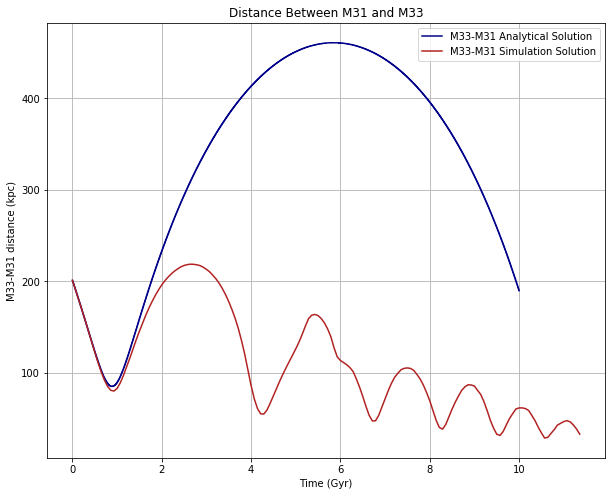

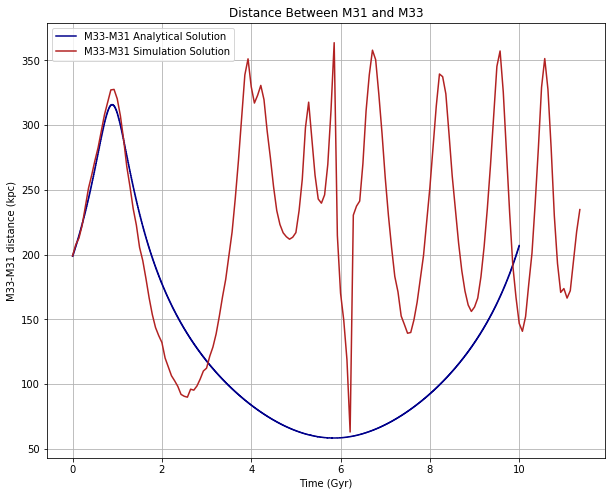

In [9]:
plt.figure(figsize=(10,8))
plt.plot(t,r,color="darkblue",label="M33-M31 Analytical Solution")
plt.plot(M33t/1000,M33r,color="firebrick", label="M33-M31 Simulation Solution")
plt.title("Distance Between M31 and M33")
plt.ylabel("M33-M31 distance (kpc)")
plt.xlabel("Time (Gyr)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,8))
plt.plot(t,v,color="darkblue",label="M33-M31 Analytical Solution")
plt.plot(M33t/1000,M33v,color="firebrick", label="M33-M31 Simulation Solution")
plt.title("Distance Between M31 and M33")
plt.ylabel("M33-M31 distance (kpc)")
plt.xlabel("Time (Gyr)")
plt.legend()
plt.grid()
plt.show()

The Plots begin the same but then wildly diverge, beginning right before 2 Gyr

Likely this divergence is because the analytical solution fails to account for the changing mass of the galaxies as M33 is stripped and M31 and MW begin to exchange materials. To inlcude the milky way, my first thought is to do the above operation for M31-MW, then for M33-(M31-MW system).